# Allocate Benchmarks

In [1]:
# select measurement file
file_name = "../output/2024-08-06 11-22-51 new.json"

# select style options
grey_fill_between = False

if grey_fill_between:
    fill_between_args = {"color": "grey"}
else:
    fill_between_args = {}


In [2]:
# parse data
import json

with open(file_name) as file:
    raw_data = json.load(file)

In [3]:
from util.convert import convert_data
from IPython.core.display import HTML

# filter and convert data
allocate_min = convert_data(raw_data, "allocate_min", ["mean", "min", "max", "options.object_size", "machine_name", "cold_start", "repetitions"])
allocate_max = convert_data(raw_data, "allocate_max", ["mean", "min", "max", "options.object_size", "machine_name", "cold_start", "repetitions"])
allocate_case1 = convert_data(raw_data, "allocate_case_1", ["mean", "min", "max", "options.object_size", "machine_name", "cold_start", "repetitions"])

display(HTML("<b>MIN Data:</b>"))
display(allocate_min.head())
display(HTML("<b>MAX Data:</b>"))
display(allocate_max.head())
display(HTML("<b>Case 1 Data:</b>"))
display(allocate_case1.head())

,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms
0,5525.0,5525,5525,0,esp32c3,5,5,16000
1,5565.0,5565,5565,32,esp32c3,5,5,16000
2,5592.0,5592,5592,64,esp32c3,5,5,16000
3,5619.0,5619,5619,96,esp32c3,5,5,16000
4,5645.0,5645,5645,128,esp32c3,5,5,16000


,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms
0,144192.0,144192,144192,0,esp32c3,5,5,16000
1,68982.0,68982,68982,32,esp32c3,5,5,16000
2,64192.0,64192,64192,64,esp32c3,5,5,16000
3,84983.0,84983,84983,96,esp32c3,5,5,16000
4,112192.0,112192,112192,128,esp32c3,5,5,16000


,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms
0,133692.0,133692,133692,0,esp32c3,5,5,16000
1,37720.0,37720,37720,32,esp32c3,5,5,16000
2,5592.0,5592,5592,64,esp32c3,5,5,16000
3,5618.0,5618,5618,96,esp32c3,5,5,16000
4,5645.0,5645,5645,128,esp32c3,5,5,16000


In [4]:
from util.convert import get_storage_measurement
from IPython.core.display import HTML

(storage_read, storage_write) = get_storage_measurement(raw_data, allocate_max["options.object_size"].max())

display(HTML("<b>READ Data:</b>"))
display(storage_read.head())
display(HTML("<b>WRITE Data:</b>"))
display(storage_write.head())

,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms
0,2637.0,2637,2637,0,esp32c3,5,5,16000
1,23512.0,23512,23512,32,esp32c3,5,5,16000
2,48354.0,48354,48354,64,esp32c3,5,5,16000
3,69229.0,69229,69229,96,esp32c3,5,5,16000
4,96354.0,96354,96354,128,esp32c3,5,5,16000


,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms
0,3910.0,3910,3910,0,esp32c3,5,5,16000
1,32002.0,32002,32002,32,esp32c3,5,5,16000
2,48189.0,48189,48189,64,esp32c3,5,5,16000
3,68980.0,68980,68980,96,esp32c3,5,5,16000
4,96190.0,96190,96190,128,esp32c3,5,5,16000


Text(0.5, 1.0, 'Allocate Latency for "esp32c3"')

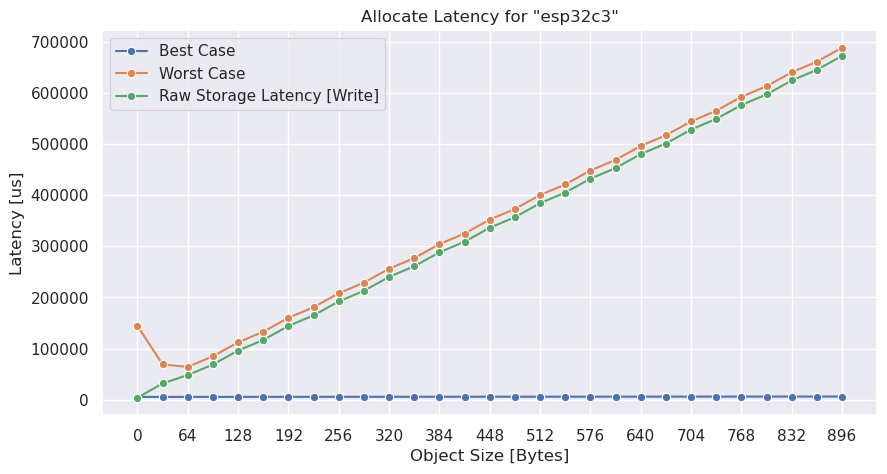

In [5]:
from util.plot import set_gird
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)

if len(allocate_min) != 0:
    sns.lineplot(ax=ax, data=allocate_min, x="options.object_size", y="mean", label="Best Case", markers=["o"], marker="o")
    ax.fill_between(allocate_min["options.object_size"], allocate_min["min"], allocate_min["max"], alpha=0.2, **fill_between_args)

if len(allocate_max) != 0:
    sns.lineplot(ax=ax, data=allocate_max, x="options.object_size", y="mean", label="Worst Case", markers=["o"], marker="o")
    ax.fill_between(allocate_max["options.object_size"], allocate_max["min"], allocate_max["max"], alpha=0.2, **fill_between_args)

if len(storage_write) != 0:
    sns.lineplot(ax=ax, data=storage_write, x="options.object_size", y="mean", label="Raw Storage Latency [Write]", markers=["o"], marker="o")
    ax.fill_between(storage_write["options.object_size"], storage_write["min"], storage_write["max"], alpha=0.2, **fill_between_args)

set_gird(64, max(allocate_min["options.object_size"].max(), allocate_max["options.object_size"].max()), ax)

ax.set_xlabel("Object Size [Bytes]")
ax.set_ylabel("Latency [us]")
ax.set_title("Allocate Latency for \"" + allocate_min["machine_name"][0] + "\"")
#plt.axis([200, 300, 10000, 15000])

# Final Plot

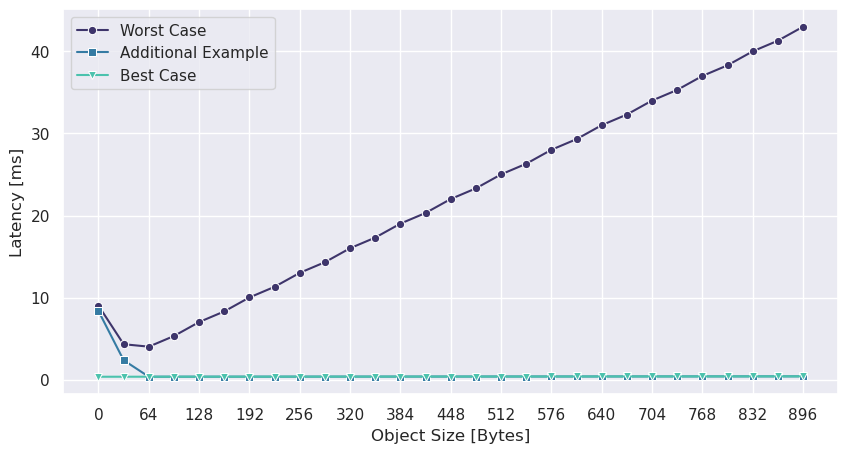

In [16]:
from util.plot import set_gird, save_plot, set_theme
from util.convert import scale_data
import seaborn as sns
import matplotlib.pyplot as plt

set_theme()

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)

unit = "ms"

if len(allocate_max) != 0:
    allocate_max_scaled = scale_data(allocate_max, unit)
    sns.lineplot(ax=ax, x=allocate_max_scaled["options.object_size"], y=allocate_max_scaled["mean"], label="Worst Case", markers=["o"], marker="o")
    ax.fill_between(allocate_max_scaled["options.object_size"], allocate_max_scaled["min"], allocate_max_scaled["max"], alpha=0.2, **fill_between_args)

if len(allocate_case1) != 0:
    allocate_case1_scaled = scale_data(allocate_case1, unit)
    sns.lineplot(ax=ax, x=allocate_case1_scaled["options.object_size"], y=allocate_case1_scaled["mean"], label="Additional Example", markers=["o"], marker="s")
    ax.fill_between(allocate_case1_scaled["options.object_size"], allocate_case1_scaled["min"], allocate_case1_scaled["max"], alpha=0.2, **fill_between_args)

if len(allocate_min) != 0:
    allocate_min_scaled = scale_data(allocate_min, unit)
    sns.lineplot(ax=ax, x=allocate_min_scaled["options.object_size"], y=allocate_min_scaled["mean"], label="Best Case", markers=["o"], marker="v")
    ax.fill_between(allocate_min_scaled["options.object_size"], allocate_min_scaled["min"], allocate_min_scaled["max"], alpha=0.2, **fill_between_args)

set_gird(64, max(allocate_min["options.object_size"].max(), allocate_max["options.object_size"].max()), ax)

ax.set_xlabel("Object Size [Bytes]")
ax.set_ylabel(f"Latency [{unit}]")
#plt.axis([200, 300, 10000, 15000])

save_plot("allocate")

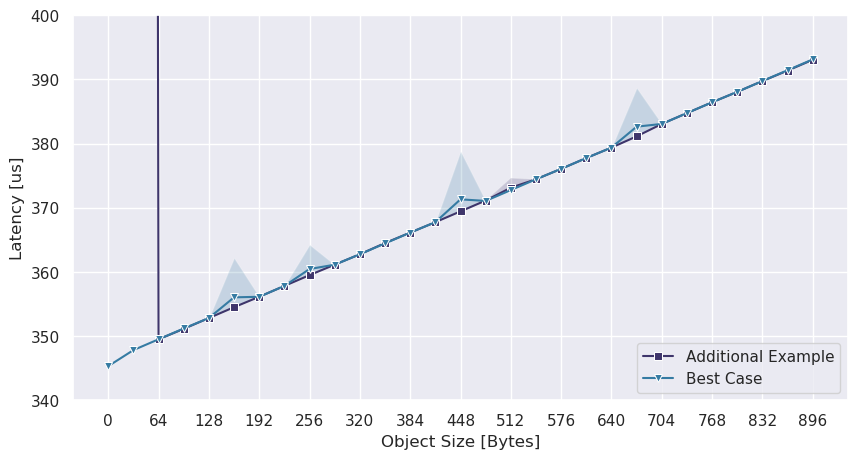

In [15]:
from util.plot import set_gird, save_plot, set_theme
from util.convert import scale_data
import seaborn as sns
import matplotlib.pyplot as plt

set_theme()

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)

unit = "us"

# if len(allocate_max) != 0:
#     allocate_max_scaled = scale_data(allocate_max, unit)
#     sns.lineplot(ax=ax, x=allocate_max_scaled["options.object_size"], y=allocate_max_scaled["mean"], label="Worst Case", markers=["o"], marker="o")
#     ax.fill_between(allocate_max_scaled["options.object_size"], allocate_max_scaled["min"], allocate_max_scaled["max"], alpha=0.2, **fill_between_args)

if len(allocate_case1) != 0:
    allocate_case1_scaled = scale_data(allocate_case1, unit)
    sns.lineplot(ax=ax, x=allocate_case1_scaled["options.object_size"], y=allocate_case1_scaled["mean"], label="Additional Example", markers=["o"], marker="s")
    ax.fill_between(allocate_case1_scaled["options.object_size"], allocate_case1_scaled["min"], allocate_case1_scaled["max"], alpha=0.2, **fill_between_args)

if len(allocate_min) != 0:
    allocate_min_scaled = scale_data(allocate_min, unit)
    sns.lineplot(ax=ax, x=allocate_min_scaled["options.object_size"], y=allocate_min_scaled["mean"], label="Best Case", markers=["o"], marker="v")
    ax.fill_between(allocate_min_scaled["options.object_size"], allocate_min_scaled["min"], allocate_min_scaled["max"], alpha=0.2, **fill_between_args)

set_gird(64, max(allocate_min["options.object_size"].max(), allocate_max["options.object_size"].max()), ax)

ax.set_xlabel("Object Size [Bytes]")
ax.set_ylabel(f"Latency [{unit}]")
ax.set_ylim(bottom=340, top=400)
#plt.axis([200, 300, 10000, 15000])

save_plot("allocate_min")